# Titanic: Machine Learning from Disaster

### Binary classification

https://www.kaggle.com/c/titanic/data

In [1]:
import pandas as pd
from pylab import *
import numpy as np

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# helpers
from sklearn.model_selection import train_test_split
from sklearn import metrics

%matplotlib inline

In [2]:
# helpers

def map_fare(data):
    data.loc[data['Fare'] <= 7.91, 'Fare'] = 0
    data.loc[(data['Fare'] > 7.91) & (data['Fare'] <= 14.454), 'Fare'] = 1
    data.loc[(data['Fare'] > 14.454) & (data['Fare'] <= 31), 'Fare'] = 2
    data.loc[data['Fare'] > 31, 'Fare'] = 3

def map_age(data):
    data.loc[data["Age"] <= 16, "Age"] = 0
    data.loc[(data["Age"] > 16) & (data["Age"] <= 32), "Age"] = 1
    data.loc[(data["Age"] > 32) & (data["Age"] <= 48), "Age"] = 2
    data.loc[(data["Age"] > 48) & (data["Age"] <= 64), "Age"] = 3
    data.loc[data["Age"] > 64, "Age"] = 4

def map_sex(data):
    data["Sex"] = data["Sex"].map({"male": 0, "female": 1})

def map_emabarked(data):
    data["Embarked"] = data["Embarked"].map({"S": 0, "C": 1, "Q": 2})

def drop_elements(data):
    data.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1, inplace=True)

def process_missing(data):
    data["Embarked"].fillna("S", inplace=True)
    data["Fare"].fillna(data["Fare"].median(), inplace=True)
    data["Age"].fillna(data["Age"].median(), inplace=True)

In [3]:
# load data
df_train_i = pd.read_csv("data/train.csv")
df_test_i = pd.read_csv("data/test.csv")
df_test_res_i = pd.read_csv("data/result-for-test.csv")

In [4]:
# create copy of train and test data
df = df_train_i.copy()
df_test = df_test_i.copy()

In [5]:
# check empty data
print(f"Cabin - {df[pd.isnull(df['Cabin'])].shape[0]}")
print(f"Age   - {df[pd.isnull(df['Age'])].shape[0]}")
print(f"Sex   - {df[pd.isnull(df['Sex'])].shape[0]}")
print(f"SibSp - {df[pd.isnull(df['SibSp'])].shape[0]}")
print(f"Fare  - {df[pd.isnull(df['Fare']) | df['Fare'] == 0].shape[0]}")
print(f"Class - {df[pd.isnull(df['Pclass']) | df['Pclass'] == 0].shape[0]}")
print(f"Embarked - {df[pd.isnull(df['Embarked'])].shape[0]}")

Cabin - 687
Age   - 177
Sex   - 0
SibSp - 0
Fare  - 15
Class - 0
Embarked - 2


In [6]:
# process train data
drop_elements(df)
process_missing(df)
map_sex(df)
map_emabarked(df)
# map_age(df)
# map_fare(df)

# process test data
drop_elements(df_test)
process_missing(df_test)
map_sex(df_test)
map_emabarked(df_test)
# map_age(df_test)
# map_fare(df_test)

In [7]:
# print(df.columns)
df.groupby(["Pclass"])["Fare"].mean()

Pclass
1    84.154687
2    20.662183
3    13.675550
Name: Fare, dtype: float64

In [8]:
features = df[["Age", "Sex", "Pclass", "Parch", "Fare", "Embarked", "SibSp"]]
target = df["Survived"]

X = features.values
y = target.values

In [9]:
log_reg = LogisticRegression()

log_reg.fit(X, y)
y_pred = log_reg.predict(X)

scores = cross_val_score(log_reg, X, y, cv=10)
scores.mean()

0.7935410282601294

In [10]:
svc = SVC()
svc.fit(X, y)

scores = cross_val_score(svc, X, y, cv=10,scoring="accuracy")
scores.mean()

0.70282771535580524

In [11]:
rand_forest = RandomForestClassifier(max_depth=5, n_estimators=24)
rand_forest.fit(X, y) 

scores = cross_val_score(rand_forest, X, y, cv=10,scoring="accuracy")
scores.mean()

0.82054562478719784

In [12]:
rand_forest = RandomForestClassifier()

param_grid = dict({
    "n_estimators" :list(range(10, 50)),
    "max_depth": list(range(1,7))
})
grid = GridSearchCV(rand_forest, param_grid, cv = 10, scoring="accuracy")
grid.fit(X, y)
print(grid.best_score_)
print(grid.best_params_)

0.833894500561
{'max_depth': 6, 'n_estimators': 47}


In [13]:
output = svc.predict(df_test.values).astype(int)
df_output = pd.DataFrame()
df_output["PassengerId"] = df_test_i["PassengerId"]
df_output["Survived"] = output
df_output.to_csv("data/output.csv",index=False)

In [14]:
grouped_by_sex = df_train_i.groupby(by=["Sex", "Survived"])["Survived"].count()
grouped_by_class = df_train_i.groupby(by=["Pclass", "Survived"])["Survived"].count()
grouped_by_sib = df_train_i.groupby(by=["SibSp", "Survived"])["Survived"].count()

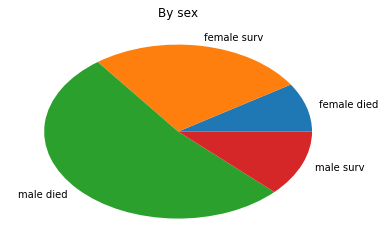

In [15]:
title("By sex")
pie(grouped_by_sex.values, labels=["female died", "female surv", "male died", "male surv"]);

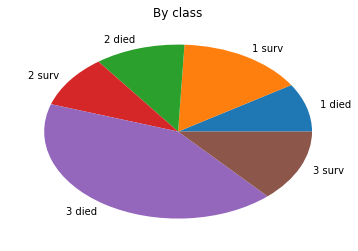

In [16]:
title("By class")
pie(grouped_by_class.values, labels=["1 died", "1 surv", "2 died", "2 surv", "3 died", "3 surv"]);

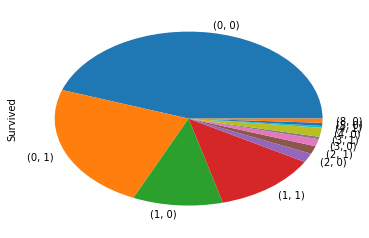

In [17]:
grouped_by_sib.plot(kind="pie");

female    233
male      109
Name: Sex, dtype: int64

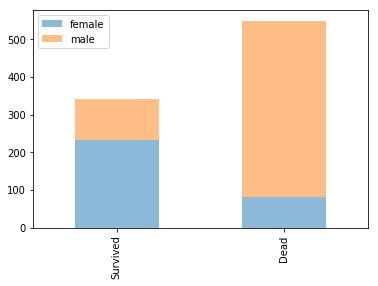

In [18]:
survived_sex = df[df['Survived']==1]['Sex'].map({0:"male", 1:"female"}).value_counts()
dead_sex = df[df['Survived']==0]['Sex'].map({0:"male", 1:"female"}).value_counts()
df_plot_sex = pd.DataFrame([survived_sex,dead_sex])
df_plot_sex.index = ['Survived','Dead']
df_plot_sex.plot(kind='bar',stacked=True, alpha=0.5);
survived_sex